### White Dwarf

In [29]:

url = "https://cdsarc.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad"
catalog = download(url)

"/tmp/jl_BOPuVIn4la"

In [30]:

using CSV
using DataFrames
using PyPlot

In [31]:

df = CSV.read(catalog, DataFrame, comment="#", skipto=4, 
              types=[Float64, Float64], delim='\t', ignorerepeated=true, 
              silencewarnings=true);

In [32]:

dropmissing!(df) # This drops datapoints that do not have any data assigned with them or ones missing data.

Row,Mass,Rad
,Float64,Float64
1,1.37,0.00434
2,1.3,0.00423
3,1.16,0.0067
4,1.03,0.00631
5,1.171,0.006503
6,0.83,0.01
7,1.02,0.00782
8,0.9,0.00883
9,0.9,0.0088


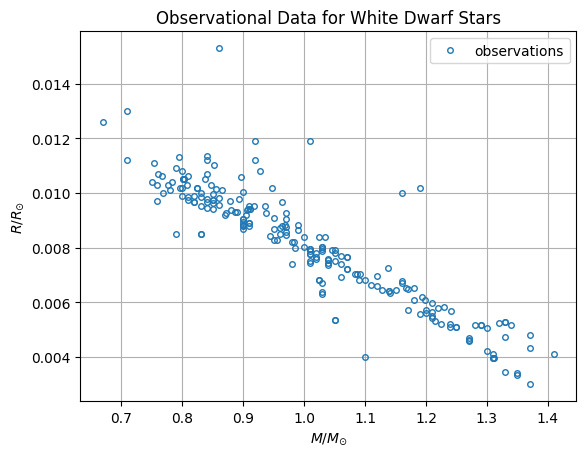

PyObject Text(0.5, 1.0, 'Observational Data for White Dwarf Stars')

In [33]:

# The constants in the plot command convert our dimensionless units to the units of the solar mass and solar radius
# plot(mass*0.71, radi*0.006, label="theory") 
plot(df.Mass, df.Rad, marker="o", linestyle="none", 
    fillstyle="none", markersize=4, label="observations")
grid(true)
xlabel(L"$M/M_{\odot}$")
ylabel(L"$R/R_{\odot}$")
legend();
title("Observational Data for White Dwarf Stars")

In [34]:

using OrdinaryDiffEqTsit5

In [49]:

"""
    white_dwarf_eqs!(dudr, u, p, r)

The right hand side of the system of 2 dimensionless differential 
equations describing the radial distribution of the density, rho(r),
and mass, m(r), inside a white dwarf star

     m' =  rho r^2
   rho' = -m rho /(gamma(\rho) r^2)

where gamma(rho) = rho^(2/3)/(3 sqrt(1 + rho^(2/3)))
"""
function white_dwarf_eqs!(dudr, u, p, r) #explanation mark in the name means parameters will change as a result of the function
    m = u[1]
    rho = u[2]
    rho_c = p
    if rho >= 0           
        w = rho^(2/3)
        gamma = w / (3 * sqrt(1 + w))
        dudr[1] = rho * r^2
        if r > 1.0e-6
            dudr[2] = - m * rho / (3 * r^2 * gamma)
        else
            dudr[2] = - r * rho_c * rho / (3 * gamma)
        end
    else                #Note from Here to next mentioned Line
        dudr[1] = 0.0
        dudr[2] = 0.0
    end                   #Is used because rho and r would be 0's in the equations above, which would cause many issues. To avoid 0 / 0 situations.
    return nothing
end

white_dwarf_eqs!

In [50]:

rho_c1 = 0.08      #  min density in the star center
rho_c2 = 100000.0  #  max density in the star center
np = 100

rhos = exp.(range(log(rho_c1), log(rho_c2), np));

In [51]:

radi = zeros(np)
mass = zeros(np);

In [52]:

rspan = (0.0, 10.0)

(0.0, 10.0)

In [53]:

for i = 1:np

    rho_c = rhos[i]
    u0 = [0.0, rho_c]
    prob = ODEProblem(white_dwarf_eqs!, u0, rspan, rho_c)

    #set up the callback
    condition(u, t, integrator) = u[2]  # stop integration when rho = 0.
    affect!(integrator) = terminate!(integrator)
    cb = ContinuousCallback(condition, affect!)
    
    sol = solve(prob, Tsit5(), callback=cb)

    
    radi[i] = sol.t[end]
    mass[i] = sol.u[end][1]
end

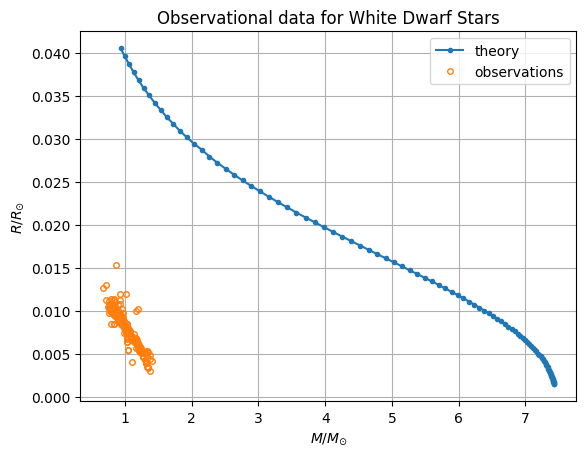

In [54]:

# The constants in the plot command convert our dimensionless units to the units of the solar mass and solar radius
plot(mass*0.71, radi*0.006, marker=".", label="theory") 
plot(df.Mass, df.Rad, marker="o", linestyle="none", 
     fillstyle="none", markersize=4, label="observations")
grid(true)
xlabel(L"$M/M_{\odot}$")
ylabel(L"$R/R_{\odot}$")
title("Observational data for White Dwarf Stars")
legend();